# Waterpixels

### Traitement préliminaire

In [23]:
import numpy as np
from scipy import signal
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import random
from skimage import io as skio
from skimage import measure
import skimage.morphology as morpho
from scipy import ndimage
from skimage import exposure
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import scipy.misc as im
from skimage import segmentation, color
from skimage.io import imread
from skimage.future import graph


plt.rcParams["figure.figsize"] = (20,20)

pathImg="tests/2018.jpg"
pathMain="solutions/2018.png"

In [2]:
#Pour les opérateurs morphologiques

def strel(forme, taille,angle = 45):
    if forme == 'diamond' : 
        return morpho.selem.diamond(taille)
    if forme == 'disk' : 
        return morpho.selem.disk(taille)
    if forme == 'square' : 
        return morpho.selem.square(taille)
    if forme == 'line' : 
        angle = int(-np.round(angle))
        angle = angle%180
        angle = np.float32(angle)/180.0*np.pi
        x = int(np.round(np.cos(angle)*taille))
        y = int(np.round(np.sin(angle)*taille))
        if x**2 + y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x = int(np.sign(np.cos(angle)))
                y = 0
            else:
                y = int(np.sign(np.sin(angle)))
                x = 0
        rr, cc = morpho.selem.draw.line(0, 0, y, x)
        rr = rr-rr.min()
        cc = cc-cc.min()
        img = np.zeros((r.max()+1, cc.max()+1))
        img[rr,cc] = 1
        returnimg
        
    raise RuntimeError('Erreur dans fonction strel : forme incomprise.')
    

## Calcul du gradient

In [3]:
derivX=[[-1,0,0,1]]
derivY=[[-1],[0],[0],[1]]
masqueX=[[-1,0,1],[-1,0,1],[-1,0,1]]
masqueY=[[-1,-1,-1],[0,0,0],[1,1,1]]

def Grey(Path):
    #Cette fonction transforme une image couleur en niveau de gris
    img=np.array(skio.imread(Path))
    new_image=rgb2gray(img)
    return new_image

def filtrer_grad_classique(Path, show = False) :
    #Cette fonction renvoie le gradient de l'image située à la destination Path en utilisant le filtre de Sobel
    image=Grey(Path)
    element = strel("disk", np.floor(3))
    image = morpho.closing(morpho.opening(image,element),element)
    
    x=signal.convolve2d(image,masqueX,"same")
    y=signal.convolve2d(image,masqueY,"same")
    if show:
        fig = plt.figure()
        ax1 = fig.add_subplot(1,3,1)
        ax2 = fig.add_subplot(1,3,2)
        ax3 = fig.add_subplot(1,3,3)
        ax1.imshow(x,cmap='gray')
        ax2.imshow(y,cmap='gray')
        ax3.imshow(np.sqrt(x**2 + y**2), cmap='gray')
        plt.show()
    return (np.sqrt(x**2 + y**2))

def filtrer_grad_morpho(Path):
    #Cette fonction calcule le gradient morphologique de l'image située à la destination Path
    image=Grey(Path)
    element = strel("disk", np.floor(3))
    image = morpho.closing(morpho.opening(image,element),element)
    elmt=strel("disk",np.floor(2))
    grad=morpho.dilation(image,elmt)-morpho.erosion(image,elmt)
    return grad



Text(0.5, 1.0, 'Gradient morphologique')

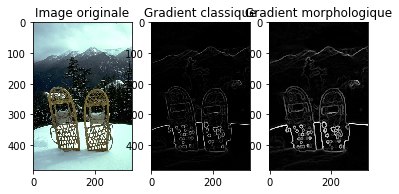

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(np.array(skio.imread(pathImg)),cmap='gray')
ax1.set_title("Image originale")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(filtrer_grad_classique(pathImg),cmap='gray')
ax2.set_title("Gradient classique")

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(filtrer_grad_morpho(pathImg),cmap='gray')
ax3.set_title("Gradient morphologique")

# Configuration de la grille et des marqueurs

In [5]:
connexite_6 = np.array([[np.inf,np.inf, 2, np.inf, np.inf],
                  [2, 2, 1, 2, 2],
                  [2, 1, 0 , 1, 2],
                  [2, 2, 1,2,2],
                  [np.inf,np.inf,2 ,np.inf, np.inf]])

def diviseMasque(g):
    # Cette fonction sépare le masque g en deux masques. Si la taille du masque est 2*n + 1 alors le premier (g1) est 
    # composé uniquement des premières n lignes et les premiers n éléments de la n+1 ème ligne. Le deuxième (g2)
    # contient les derniers n éléments de la n+1ème ligne et les dernières n lignes.
    
    n = g.shape[0]
    g1, g2 = np.ones([n//2+1,n])* np.inf, np.ones([n//2+1,n])* np.inf
    for i in range(n//2):
        g1[i, : ] = g[i, :]
        g2[i + 1, : ] = g[n//2 + i + 1 , :]
    g1[n//2, 0:n//2+1] = g[n//2, 0:n//2+1]
    g2[0, n//2:n] = g[n//2, n//2:n]
    
    return(g1,g2)


def distance(g, mark):
    # g est le masque qu'on utilise pour calculer les distances, mark est un array qui contient déjà les marqueurs
    # Elle renvoie la carte des distances
    g1, g2 = diviseMasque(g)
    m = g.shape[0]
    marker = np.copy(mark)
    marker[marker == 1] = np.inf
    
    # D'abord le parcours pour g2
    for i in range(marker.shape[0]):
        for j in range(marker.shape[1]):
            if marker[i,j] != np.inf:
                for k in range(m//2+1):
                    for l in range(-(m//2), m//2+1):
                        if not (i + k >= marker.shape[0] or j+l >= marker.shape[1] or j + l < 0):
                            marker[i+k, j+l] = min(marker[i,j] + g2[k, l + m//2], marker[i+k, j+l])
    for i in range(marker.shape[0]-1, -1, -1):
        for j in range (marker.shape[1]-1, -1,-1):
            if marker[i,j] != np.inf:
                for k in range(0, -(m//2)-1, -1):
                    for l in range(m//2, -(m//2)-1, -1):
                        if not (i+k <0 or j+l < 0 or j+l >= marker.shape[1]):
                            marker[i+k, j+l] = min(marker[i,j] + g1[k+m//2, l + m//2], marker[i+k, j+l])
    return(marker)
    
     
def marqueurs(n,m,l): #n nombre de lignes, m de colonnes et l le pas
    #retourne les marqueurs équidistants, situés à une distance l les uns des autres
    #  On met  le fond à 1 et les marqueurs à 0.
    marqueur = np.ones([n,m])
    res = 0
    while (res*(l//10*8)<n):
        if res % 2 == 0 :
            for i in range(m//l+1):
                if (i*l < m) :
                    marqueur[res*(l//10*8),i*l] = 0
        else :
            for i in range(m//l+1):
                if (i*l+l//2) < m :
                    marqueur[res*(l//10*8),i*l+l//2] = 0
        res=res+1
    return(marqueur)



def pattern(g,I,l,seuil):
    # Elle renvoie la matrice composée des cellules de la grille (différenciées par leur contours). On met à 0 le fond
    # et à 1 les contours.
    if seuil > l:
        return("non")
    n = I.shape[0]
    m = I.shape[1]
    I2 = np.zeros([int(np.ceil(n/(l//10*8)) *(l//10*8)+1), int(np.ceil(m/(l//2))*(l//2)+1)])
    marker = marqueurs(I2.shape[0], I2.shape[1],l) #on calcule la position des marqueurs 
    D = distance(g,marker) #on calcule la carte des distances à partir de ces marqueurs 
    for i in range(I2.shape[0]):
         for j in range(I2.shape[1]):
            if D[i][j]>seuil:# Les contours sont les pixels dont les valeurs dans la carte des distances est supérieure au seuil
                D[i][j]=1
            else:
                D[i][j]=0
    Dfin = D[:n,:m]
    return(Dfin)
    
def min_locaux(grad, pas, seuil, g):
    #Cette fonction prend en argument le gradient de l'image, le pas, le seuil et le masque g
    # Cette fonction renvoie : 
    # 1. J, un array qui contient les markeurs déjà dans le format dont la fonction distance a besoin : des 1 partout
    #    sauf pour les markeurs, où ça vaut 0.
    # 2. listeMinK, les markeurs mais sous le format d'une liste
    # 3. pat, le pattern des hexagones.
    
    #création des labels
    n = grad.shape[0]
    m = grad.shape[1]
    J = np.ones([n,m])
    pat = pattern(g,J,pas,seuil)
    label,nb_label = measure.label(pat, background = 1, connectivity = 1, return_num = True) 
    
    #étude par région pour trouver les min. Chaque label correspond à un hexagone/segment de l'image.
    prop = measure.regionprops(label, intensity_image = grad)
    for k in range(0, nb_label):
        minK = prop[k].min_intensity #on calcule le min du gradient sur la zone étudiée 
        bbox = prop[k].bbox
        box = np.zeros([bbox[2]-bbox[0], bbox[3]-bbox[1]]) #on obtient une "boite" encadrant la zone étudiée 
        for i in range(bbox[0], np.min([bbox[2]+1,n])):
            for j in range(bbox[1], np.min([bbox[3]+1,m])): #on parcourt la boite
                if label[i][j] == k+1:    #Si le pixel est bien dans l'hexagone/le label
                    if (grad[i][j] == minK ): #Et que le gradient est minimum en ce pixel
                        box[i-bbox[0]][j-bbox[1]] = 1     # on note ce pixel dans box
                        
        #verification que les min ne fassent qu'une composante connexe
        mini_labels,nb = measure.label(box,background=0,connectivity=1,return_num=True)
        mini_prop = measure.regionprops(mini_labels) #on labélise box, chaque mini_label correspond à une composante connexe
        mini = 0
        zone = 0
        for i in range(nb): #on cherche la plus grande composante connexe en nombre de pixels
            n_pixels = mini_prop[i].area
            if n_pixels > mini:
                mini = n_pixels
                zone = i+1
        for i in range(bbox[0],bbox[2]): #on parcourt chaque composante connexe, si le pixel fait partie de la plus grande, il est noté comme marqueur 
            for j in range(bbox[1],bbox[3]):
                if mini_labels[i-bbox[0]][j-bbox[1]] == zone: 
                    J[i][j] = 0 
    return(J,pat)



Text(0.5, 1.0, 'min du gradient')

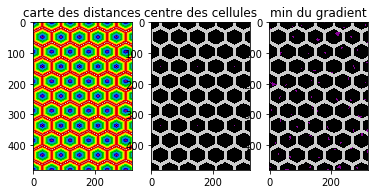

In [6]:
J,  pat = min_locaux(filtrer_grad_morpho(pathImg), 60, 25, connexite_6)
n, m, l = J.shape[0], J.shape[1], 60
mark = marqueurs(int(np.ceil(n/(l//10*8)) *(l//10*8)+1), int(np.ceil(m/(l//2))*(l//2)+1),l)
d = distance(connexite_6, mark)[:n,:m]

fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(d, cmap = 'nipy_spectral')
ax1.set_title("carte des distances")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(1-mark[:n,:m] + 10*pat, cmap = 'nipy_spectral')
ax2.set_title("centre des cellules")

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(1-J + 10*pat, cmap = 'nipy_spectral')
ax3.set_title("min du gradient")

Carte de distances hexagonale et choix des marqueurs selon les deux méthodes.

## Gradient régularisé spatialement et égalisation des histogrammes


In [7]:
def mixgradients(path, l, seuil,g, version,coeff):
    # Cette fonction renvoie le gradient régularisé spatialement ainsi que la matrice avec les marqueurs.
    # La version 1 est celle des minimums du gradient,
    # la version 0 est celle où les marqueurs du centre de la grille.
    
    # On commence par trouver les cartes des distances de chaque méthode.
    grad = filtrer_grad_morpho(path)
    n = grad.shape[0] 
    m = grad.shape[1]
    if version == 1 :
        markArray , pat = min_locaux(grad,l,seuil, g)
        f = distance(g, markArray)[:n,:m]
        forme = exposure.equalize_hist(f)
    else : 
        grad2 = np.zeros([int(np.ceil(n/(l//10*8)) *(l//10*8)+1), int(np.ceil(m/(l//2))*(l//2)+1)])
        mark = marqueurs(grad2.shape[0], grad2.shape[1],l)
        f = (distance(g, mark)[:n,:m])
        forme = exposure.equalize_hist(f)
        markArray = mark[:n, :m]
        
    # On crée le gradient régularisé
    water = grad/grad.max() + (forme/forme.max())*coeff
    return(water,markArray)

Text(0.5, 1.0, 'Histogramme originel')

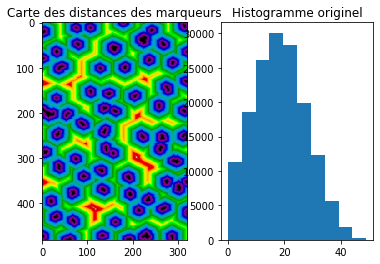

In [8]:
dmark = distance(connexite_6,J)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(dmark, cmap = 'nipy_spectral')
ax1.set_title("Carte des distances des marqueurs")
ax2 = fig.add_subplot(1,2,2)
plt.hist(np.ndarray.flatten(dmark))
plt.title("Histogramme originel")

L'histogramme montre qu'il y a une petite quantité de distances trop grandes.

Text(0.5, 1.0, 'Histogramme égalisé')

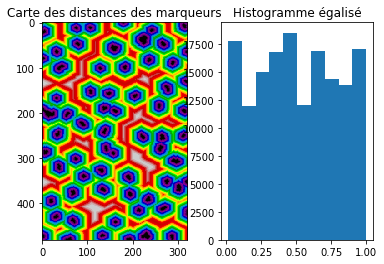

In [9]:
dreduite = exposure.equalize_hist(dmark)
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(dreduite, cmap = 'nipy_spectral')
ax1.set_title("Carte des distances des marqueurs")
ax2 = fig.add_subplot(1,2,2)
plt.hist(np.ndarray.flatten(dreduite))
plt.title("Histogramme égalisé")

Nouvelle carte des distances et histogramme régularisé

Text(0.5, 1.0, 'minimum k = 1')

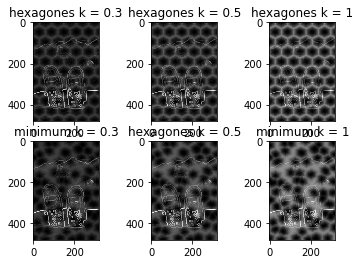

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
water1,mark1 = mixgradients(pathImg,60,25,connexite_6,0,0.3)
ax1.imshow(water1, cmap = 'gray')
ax1.set_title("hexagones k = 0.3")

ax2 = fig.add_subplot(2,3,2)
water2, mark2 = mixgradients(pathImg,60,25,connexite_6,0,0.5)
ax2.imshow(water2, cmap = 'gray')
ax2.set_title("hexagones k = 0.5")

ax3 = fig.add_subplot(2,3,3)
water3,mark3 = mixgradients(pathImg,60,25,connexite_6,0,1)
ax3.imshow(water3, cmap = 'gray')
ax3.set_title("hexagones k = 1")

ax4 = fig.add_subplot(2,3,4)
water4, mark4 = mixgradients(pathImg,60,25,connexite_6,1,0.3)
ax4.imshow(water4, cmap = 'gray')
ax4.set_title("minimum k = 0.3")

ax5 = fig.add_subplot(2,3,5)
water5, mark5 = mixgradients(pathImg,60,25,connexite_6,1,0.5)
ax5.imshow(water5, cmap = 'gray')
ax5.set_title("hexagones k = 0.5")

ax6 = fig.add_subplot(2,3,6)
water6, mark6 = mixgradients(pathImg,60,25,connexite_6,1,1)
ax6.imshow(water6, cmap = 'gray')
ax6.set_title("minimum k = 1")

## Ligne de partage des eaux 

In [11]:
def realWatershed(Path, l, version, coeff,g = connexite_6,printContours=False):
    # Cette fonction renvoie l'image initiale avec les lignes qui marquent la segmentation de la ligne de partage
    # des eaux. 
    seuil = l/2 -2
    img = Grey(Path)
    # On commence par calculer le gradient régularisé spatialement, puis on étiquette la matrice des marqueurs par 
    # composante connexe. Ensuite, on utilise la ligne de partage des eaux.
    water, mark = mixgradients(Path, l, seuil, g, version, coeff)
    labeled_array, num_features = measure.label(1-mark, background = 0, connectivity = 1, return_num = True)
    
    # On ajoute la matrice avec les lignes de segmentation avec l'image de départ, en faisant attention au codage en
    # niveau de gris de l'image.
    count = 0
    #Cas spécifique où l'on souhaite obtenir juste les contours
    if printContours :
        label = morpho.watershed(water, labeled_array, watershed_line = False)
        imline =mark_boundaries(np.zeros(img.shape), label, color=(1, 1, 1))
        imline = imline[:imline.shape[0], :imline.shape[1],0]
        for i in range(imline.shape[0]):
            for j in range(imline.shape[1]):
                if imline[i,j] == 1:
                    count = count+1
        CD=(count/2 + label.shape[0]*2+label.shape[1]*2)/(label.shape[0]*label.shape[1])
        print("Pour k=" +str(coeff)+',la densité de contour du watershed utilisant la méthode '+ str(version+1)+" vaut "+str(CD))
        return (imline)
    
    #Cas général
    label = morpho.watershed(water, labeled_array, watershed_line = True)
    maxx=0
    if img.max()<=1: #On vérifie comment est codée l'image entre 0 et 1 ou 0 et 255
        maxx=1
    else:
        maxx=255
    count=0
    imline = np.copy(img)
    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            if label[i,j] == 0: # On parcourt l'image et on trace des zones blanches au niveau des contours par dessus l'image
                count=count+1
                imline[i,j] = maxx
    return(imline)

Text(0.5, 1.0, 'minimum k = 1')

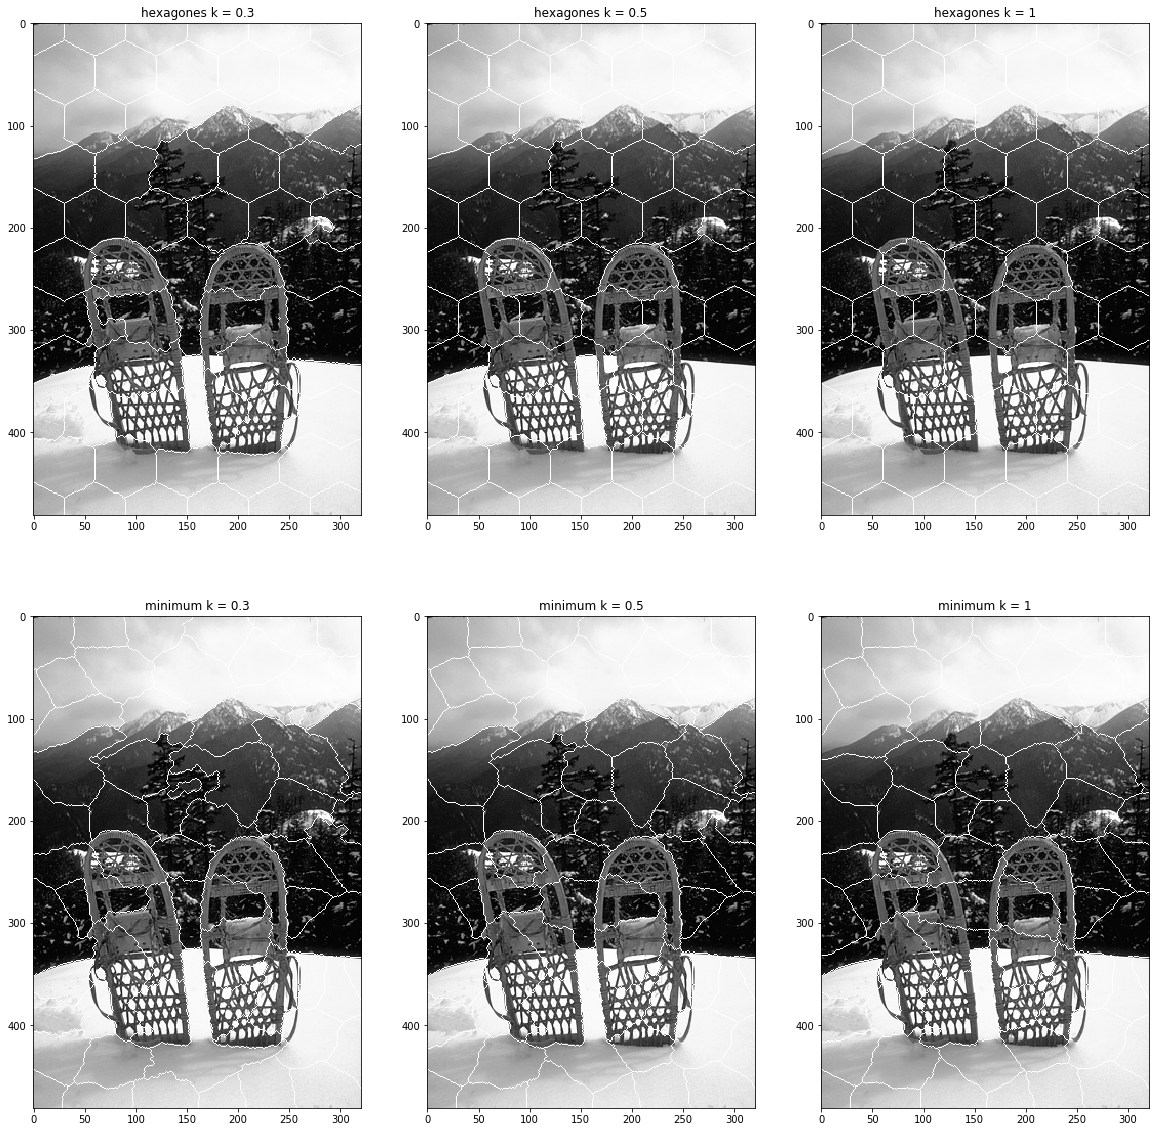

In [24]:
imline1 = realWatershed(pathImg,60,0,0.3)
imline2 = realWatershed(pathImg,60,0,0.5)
imline3 = realWatershed(pathImg,60,0,1)
imline4 = realWatershed(pathImg,60,1,0.3)
imline5 = realWatershed(pathImg,60,1,0.5)
imline6 = realWatershed(pathImg,60,1,1)

fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(imline1, cmap = 'gray')
ax1.set_title("hexagones k = 0.3")
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(imline2, cmap = 'gray')
ax2.set_title("hexagones k = 0.5")
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(imline3, cmap = 'gray')
ax3.set_title("hexagones k = 1")
ax4 = fig.add_subplot(2,3,4)
ax4.imshow(imline4, cmap = 'gray')
ax4.set_title("minimum k = 0.3")
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(imline5, cmap = 'gray')
ax5.set_title("minimum k = 0.5")
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(imline6, cmap = 'gray')
ax6.set_title("minimum k = 1")

Différents résultats en fonction de la valeur de k et de la méthode choisie

## SLIC-superpixels

In [18]:
def SLIC(path,c,n=66):
    #Cette fonction prend en argument le chemin d'une image
    #Cette fonction renvoie l'image segmentée grâce à SLIC et print la densité de contours
    img = imread(path)
    # On obtient la segmentation de l'image : chaque zone est d'une couleur différente mais il 
    # n'y a pas de ligne qui les sépare.
    img_segments = segmentation.slic(img, compactness = c, n_segments=n) 
    superpixels = color.label2rgb(img_segments, img, kind='avg')
    contours=mark_boundaries(img, img_segments)
    contours2 = mark_boundaries(np.zeros(img.shape), img_segments, color=(1, 1, 1))
    # contours2 es codé en 3 rgb, on revient à un seul niveau (noir ou blanc entre 0 et 1)
    contours2 = contours2[:contours2.shape[0], :contours2.shape[1], 0]
    count=0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if contours2[i,j] == 1:
                count=count+1
                
    CD=(count/2 + img.shape[0]*2+img.shape[1]*2)/(img.shape[0]*img.shape[1])
    print("Le coefficient de densité pour l'algorithme SLIC avec compactness = "+str(c)+ " vaut "+str(CD))
    return(contours,contours2)


Le coefficient de densité pour l'algorithme SLIC avec compactness = 1 vaut 0.06279428242045064
Le coefficient de densité pour l'algorithme SLIC avec compactness = 5 vaut 0.05669652398624361
Le coefficient de densité pour l'algorithme SLIC avec compactness = 10 vaut 0.0551259383035084
Le coefficient de densité pour l'algorithme SLIC avec compactness = 20 vaut 0.053872708078315554


Text(0.5, 1.0, 'p = 20')

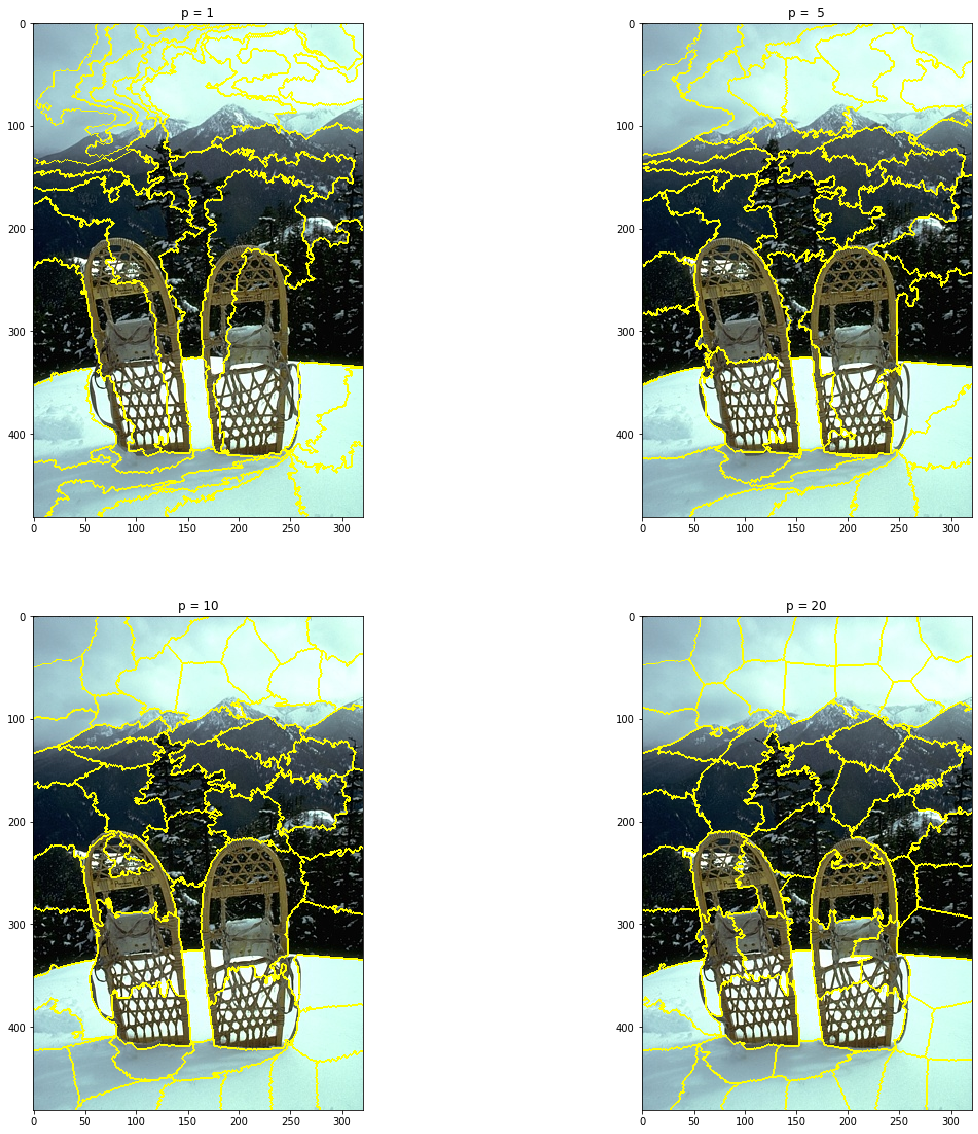

In [25]:
#Comparaison avec SLIC : on prend aussi plusieurs paramètres pour la compactness
slic1, slic_contours1 = SLIC(pathImg, 1)
slic2, slic_contours2 = SLIC(pathImg, 5)
slic3, slic_contours3 = SLIC(pathImg, 10)
slic4, slic_contours4 = SLIC(pathImg, 20)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(slic1, cmap = 'gray')
ax1.set_title("p = 1")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(slic2, cmap = 'gray')
ax2.set_title("p =  5")
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(slic3, cmap = 'gray')
ax3.set_title("p = 10")
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(slic4, cmap = 'gray')
ax4.set_title("p = 20")

## Critère d'évaluation


### Densité des contours

Ce critère est calculé pendant l'éxécution des fonctions **realWatershed** et **SLIC**. <br />
Avec nos tests, il est possible de suivre ses variations en fonction des paramètres *k*, et *p*.

In [20]:
imline1 = realWatershed(pathImg,60,0,0.3,printContours=True)
imline2 = realWatershed(pathImg,60,0,0.5,printContours=True)
imline3 = realWatershed(pathImg,60,0,1,printContours=True)
imline4 = realWatershed(pathImg,60,1,0.3,printContours=True)
imline5 = realWatershed(pathImg,60,1,0.5,printContours=True)
imline6 = realWatershed(pathImg,60,1,1,printContours=True)
slic1, slic_contours1 = SLIC(pathImg, 0.3)
slic2, slic_contours2 = SLIC(pathImg, 0.5)
slic3, slic_contours3 = SLIC(pathImg, 1)
slic4, slic_contours4 = SLIC(pathImg, 2)

Pour k=0.3,la densité de contour du watershed utilisant la méthode 1 vaut 0.044384427561997654
Pour k=0.5,la densité de contour du watershed utilisant la méthode 1 vaut 0.04293365975608966
Pour k=1,la densité de contour du watershed utilisant la méthode 1 vaut 0.04103600365282608
Pour k=0.3,la densité de contour du watershed utilisant la méthode 2 vaut 0.04946859152466629
Pour k=0.5,la densité de contour du watershed utilisant la méthode 2 vaut 0.04783323942202447
Pour k=1,la densité de contour du watershed utilisant la méthode 2 vaut 0.04679697670351876
Le coefficient de densité pour l'algorithme SLIC avec compactness = 0.3 vaut 0.06485709289447607
Le coefficient de densité pour l'algorithme SLIC avec compactness = 0.5 vaut 0.0645300224739477
Le coefficient de densité pour l'algorithme SLIC avec compactness = 1 vaut 0.06279428242045064
Le coefficient de densité pour l'algorithme SLIC avec compactness = 2 vaut 0.062000893776594714


### Coefficient de différences entre segments
Ce critère est calculé grâce à la fonction **averageMismatchFactor**.

In [29]:
def segments(contours): #Renvoie une liste de formes avec leur barycentre
    label,nb_label = measure.label(contours, background = 1, connectivity = 1, return_num = True)
    #étude par région pour trouver les formes. Chaque label correspond à un hexagone/segment de l'image.
    prop = measure.regionprops(label)
    listeFormes=[]
    maxSizeBox=[]
    maxSizeX=0
    maxSizeY=0
    mean=0
    for k in range(0, nb_label):
        bbox = prop[k].bbox
        Xbarycentre,Ybarycentre=0,0
        nbPixels=0
        sizeX=bbox[2]-bbox[0]
        sizeY=bbox[3]-bbox[1]
        if sizeX>maxSizeX:
            maxSizeX=sizeX
        if sizeY>maxSizeY:
            maxSizeY=sizeY
        box = np.zeros([sizeX, sizeY]) #on crée une "boite" encadrant la zone étudiée 
        for i in range(sizeX):
            for j in range(sizeY): #on parcourt la boite
                if label[bbox[0]+i][bbox[1]+j] == k+1:    #Si le pixel est bien dans l'hexagone/le label
                    box[i][j]=1 #on le marque dans la boite
                    Xbarycentre+=i
                    Ybarycentre+=j
                    nbPixels+=1
        barycentre=[round(Xbarycentre/nbPixels),round(Ybarycentre/nbPixels)] #on calcule le barycentre 
        mean+=nbPixels
        listeFormes.append([box,barycentre])
    
    return (listeFormes,[maxSizeX,maxSizeY],mean/nb_label)

def sommeSegments(segments,maxSizeBox): #Somme toutes les formes en alignqnt les bqrycentres
    sizeX,sizeY=maxSizeBox[0],maxSizeBox[1]
    Box=np.zeros((2*maxSizeBox[0],2*maxSizeBox[1]))
    for s in segments:
        M=s[0]
        Xbary=s[1][0]
        Ybary=s[1][1]
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                Box[sizeX+(i-Xbary)][sizeY+(j-Ybary)]+=M[i][j] #On somme toutes les formes en placant leur barycentre au point (sizeX,sizeY)
    return Box 

def card(D): #mesure le cardinal en pixel d'une forme
    sum=0
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if D[i][j]:
                sum+=1
    return sum

def formeMoyenne(meanPix,Sum): #Donne la forme moyenne des segments 
    i=0
    S=np.array(Sum)>i
    while card(S)>meanPix:
        i=i+1
        S=np.array(Sum)>i
    return (S)
    
def summ(A,baryA,B,baryB): #Sommer deux formes 
    Xa,Ya=A.shape[0],A.shape[1]
    Xb,Yb=B.shape[0],B.shape[1]
    X=max(Xa,Xb)
    Y=max(Ya,Yb)
    M=np.zeros((2*X,2*Y))
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            M[X+(i-baryA[0])][Y+(j-baryA[1])]+=A[i][j]
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            M[X+(i-baryB[0])][Y+(j-baryB[1])]+=B[i][j]
    return M

def mismatchFactor(A,baryA,B,baryB): #Calcule le mismatch factor pour deux formes 
    S=summ(A,baryA,B,baryB)
    Union=np.array(S)>=1 
    UnionStricte=np.array(S)==1
    mismatch=card(UnionStricte)/card(Union)
    return mismatch

def barycentre(A): #calcule le barycentre d'une forme 
    Xbarycentre=0
    Ybarycentre=0
    nbPixels=0
    for i in range(A.shape[0]):
            for j in range(A.shape[1]): 
                    Xbarycentre+=i
                    Ybarycentre+=j
                    nbPixels+=1
    bary=[round(Xbarycentre/nbPixels),round(Ybarycentre/nbPixels)]
    return bary

def averageMismatchFactor(contours):#prend en entrée une image de fond noir avec les contours en blanc
    ListeSegments,maxSizeBox,tailleMoyenne=segments(contours)
    S=sommeSegments(ListeSegments,maxSizeBox)
    forme=formeMoyenne(tailleMoyenne,S)
    bary=barycentre(forme)
    mismatch=0
    for s in ListeSegments:
        m=mismatchFactor(s[0],s[1],forme,bary)
        mismatch+=m
    return mismatch/len(ListeSegments)

In [30]:
print("Average mismatch avec l'algorithme de watershed utilisant la méthode 1 avec k=0.3 vaut "+str(averageMismatchFactor(imline1)))
print("Average mismatch avec l'algorithme de watershed utilisant la méthode 1 avec k=0.5 vaut "+str(averageMismatchFactor(imline2)))
print("Average mismatch avec l'algorithme de watershed utilisant la méthode 1 avec k=1   vaut "+str(averageMismatchFactor(imline3)))
print("Average mismatch avec l'algorithme de watershed utilisant la méthode 2 avec k=0.3 vaut "+str(averageMismatchFactor(imline4)))
print("Average mismatch avec l'algorithme de watershed utilisant la méthode 2 avec k=0.5 vaut "+str(averageMismatchFactor(imline5)))
print("Average mismatch avec l'algorithme de watershed utilisant la méthode 2 avec k=1   vaut "+str(averageMismatchFactor(imline6)))
print("Average mismatch avec l'algorithme SLIC avec compactness=1 vaut "+str(averageMismatchFactor(slic_contours1)))
print("Average mismatch avec l'algorithme SLIC avec compactness=5 vaut "+str(averageMismatchFactor(slic_contours2)))
print("Average mismatch avec l'algorithme SLIC avec compactness=10 vaut "+str(averageMismatchFactor(slic_contours3)))
print("Average mismatch avec l'algorithme SLIC avec compactness=20 vaut "+str(averageMismatchFactor(slic_contours4)))

Average mismatch avec l'algorithme de watershed utilisant la méthode 1 avec k=0.3 vaut 0.35407235383062813
Average mismatch avec l'algorithme de watershed utilisant la méthode 1 avec k=0.5 vaut 0.286995808743787
Average mismatch avec l'algorithme de watershed utilisant la méthode 1 avec k=1   vaut 0.24502706158273746
Average mismatch avec l'algorithme de watershed utilisant la méthode 2 avec k=0.3 vaut 0.42016312253321664
Average mismatch avec l'algorithme de watershed utilisant la méthode 2 avec k=0.5 vaut 0.3874069379439736
Average mismatch avec l'algorithme de watershed utilisant la méthode 2 avec k=1   vaut 0.3569876487736679
Average mismatch avec l'algorithme SLIC avec compactness=1 vaut 0.9557095966053651
Average mismatch avec l'algorithme SLIC avec compactness=5 vaut 0.8926353627038991
Average mismatch avec l'algorithme SLIC avec compactness=10 vaut 0.8165262121630052
Average mismatch avec l'algorithme SLIC avec compactness=20 vaut 0.8151180847161494


### Adhérence aux contours

Ce critère est calculé par la fonction **adherence** qui est ci dessous.

In [38]:
def whitecontours(Path):
    # Cette fonction prend en entrée une image segmentée à la main (tirée de la base de données de Berkeley)
    # et la modifie de façon à avoir que des 0 et des 1
    im =np.array(skio.imread(Path))
    imwhite = np.zeros(im.shape)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i,j] > 60: #60 est le seuil à partir duquel on considère que le pixel est blanc
                imwhite[i,j] = 1 
    return(imwhite)
    
def adherence(contours_main,contours_algo):
    #Cette fonction prend en entrée une image, l'image segmentée à la main et l'image segmentée grâce à un algorithme
    #Cette fonction renvoie une mesure de l'adhérence de contours_algo aux contours (en se basant sur la segmentation à la main)
    count=0
    count_correspondances=0
    for i in range(contours_main.shape[0]):
        for j in range(contours_main.shape[1]): #on parcourt l'image
                if contours_main[i,j]==1: # on arrive sur un pixel p du contour pour la segmentation à la main
                    count=count+1
                    res,x,y=0,-3,-3
                    while res==0 and -4<x<4 and 0<i+x<contours_main.shape[0] :
                        while res==0 and -4<y<4 and  0<j+y<contours_main.shape[1]: #on cherche dans un voisinage du pixel si il existe un contour déterminé algorithmiquement
                            if contours_algo[i+x][j+y]==1:
                                count_correspondances+=1 
                                res=1
                            y=y+1
                        x=x+1
            #on renvoie le pourcentage de pixels issus d'un contours à la main qui sont "proches" d'un contours algorithmique 
    return (count_correspondances/count)


Text(0.5, 1.0, 'Image segmentée à la main')

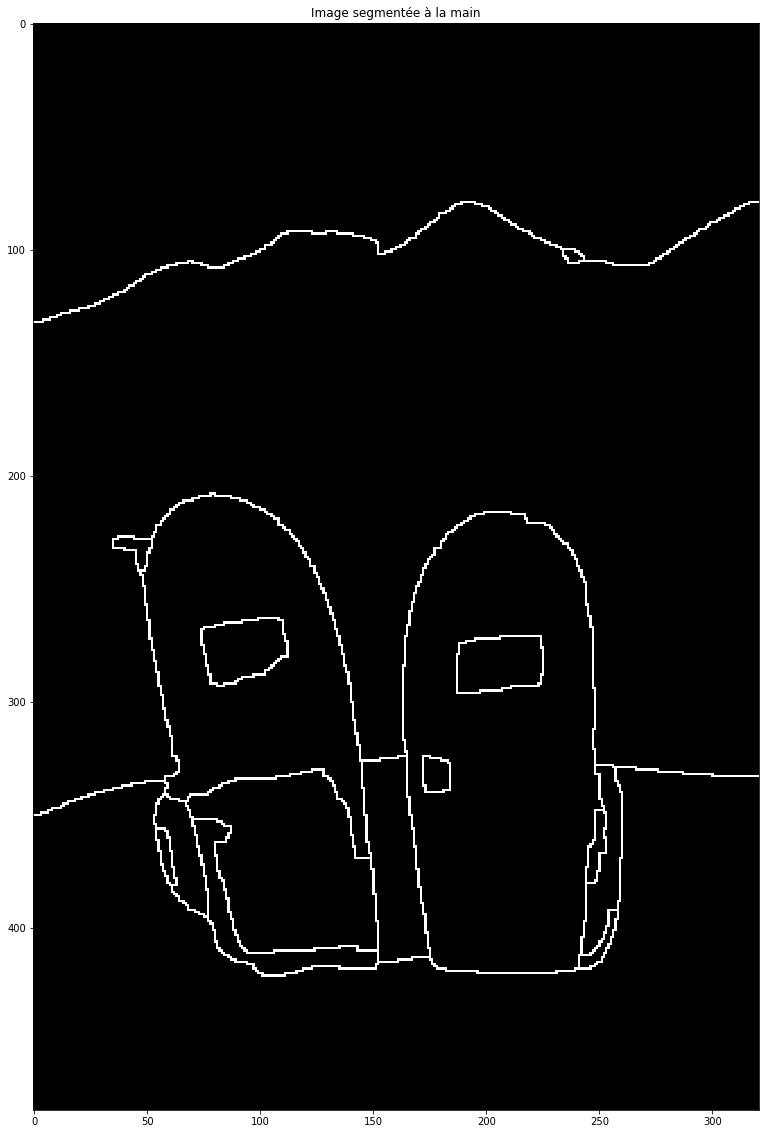

In [32]:
cmain = whitecontours(pathMain)
plt.imshow(cmain,cmap = 'gray')
plt.title("Image segmentée à la main")

In [33]:
# Nous recommençons la segmentation mais de façon à se mettre dans le même format que SLIC
cline1 = realWatershed(pathImg,60,0,0.3, printContours = True)
cline2 = realWatershed(pathImg,60,0,0.5, printContours = True)
cline3 = realWatershed(pathImg,60,0,1, printContours = True)
cline4 = realWatershed(pathImg,60,1,0.3, printContours = True)
cline5 = realWatershed(pathImg,60,1,0.5, printContours = True)
cline6 = realWatershed(pathImg,60,1,1, printContours = True)

Pour k=0.3,la densité de contour du watershed utilisant la méthode 1 vaut 0.044384427561997654
Pour k=0.5,la densité de contour du watershed utilisant la méthode 1 vaut 0.04293365975608966
Pour k=1,la densité de contour du watershed utilisant la méthode 1 vaut 0.04103600365282608
Pour k=0.3,la densité de contour du watershed utilisant la méthode 2 vaut 0.04946859152466629
Pour k=0.5,la densité de contour du watershed utilisant la méthode 2 vaut 0.04783323942202447
Pour k=1,la densité de contour du watershed utilisant la méthode 2 vaut 0.04679697670351876


Résultats de l'adhérence pour la méthode des centres des cellules

In [39]:
print("k = 0.3; BR = " + str(adherence(cmain,cline1)))
print("k = 0.5; BR = " + str(adherence(cmain,cline2)))
print("k = 1.0; BR = " + str(adherence(cmain,cline3)))

k = 0.3; BR = 0.4382845188284519
k = 0.5; BR = 0.344839609483961
k = 1.0; BR = 0.23500697350069735


Résultats de l'adhérence pour la méthode du minimum du gradient

In [40]:
print("k = 0.3; BR = " + str(adherence(cmain,cline4)))
print("k = 0.5; BR = " + str(adherence(cmain,cline5)))
print("k = 1.0; BR = " + str(adherence(cmain,cline6)))

k = 0.3; BR = 0.4616457461645746
k = 0.5; BR = 0.42677824267782427
k = 1.0; BR = 0.3423988842398884


Résultats de l'adhérence pour SLIC

In [41]:
print("p = 1; BR = " + str(adherence(cmain,slic_contours1)))
print("p = 5; BR = " + str(adherence(cmain,slic_contours2)))
print("p = 10; BR = " + str(adherence(cmain,slic_contours3)))
print("p = 20; BR = " + str(adherence(cmain,slic_contours4)))

p = 1; BR = 0.40341701534170155
p = 5; BR = 0.4292189679218968
p = 10; BR = 0.4313110181311018
p = 20; BR = 0.48535564853556484


Nous remarquerons que la valeur du coefficient de régularisation spatiale *k* et le facteur de compacité *p* de SLIC influent directement sur l'adhérence des contours et la régularité des régions de segmentation. <br />
La méthode à privilegier pour l'adhérence aux contours est celle des minimums du gradient avec un *k* petit. <br />
*k* est inversement proportionnel à la densité des contours. Il convient d'opter pour la méthode des centres des cellules si on veut que cette valeur soit faible ou obtenir une grande régularité dans la forme des segments, avec un *k* grand.<br />